In [3]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

### Preparation

In [17]:
# Read the database and eliminate the repeated index column
df = pd.read_csv("profit_x_y.csv")
df = df.drop("Unnamed: 0", axis =1)
pd.set_option("display.max_columns", None)
df

,title_x,title_y,year_x,duration_x,budget_x,worlwide_gross_income_x,LANGUAGE_English_x,LANGUAGE_Chinese_x,LANGUAGE_Korean_x,PC_Marvel Studios_x,PC_Columbia Pictures_x,PC_Universal Pictures_x,PC_Warner Bros_x,PC_Twentieth Century Fox_x,PC_Walt Disney Pictures_x,autumn_x,spring_x,summer_x,winter_x,GENRE_Action_x,GENRE_Adventure_x,GENRE_Animation_x,GENRE_Biography_x,GENRE_Comedy_x,GENRE_Crime_x,GENRE_Drama_x,GENRE_Family_x,GENRE_Fantasy_x,GENRE_Horror_x,GENRE_Mystery_x,GENRE_Other_x,GENRE_Romance_x,GENRE_Sci-Fi_x,GENRE_Thriller_x,year_y,duration_y,budget_y,worlwide_gross_income_y,LANGUAGE_English_y,LANGUAGE_Chinese_y,LANGUAGE_Korean_y,PC_Marvel Studios_y,PC_Columbia Pictures_y,PC_Universal Pictures_y,PC_Warner Bros_y,PC_Twentieth Century Fox_y,PC_Walt Disney Pictures_y,autumn_y,spring_y,summer_y,winter_y,GENRE_Action_y,GENRE_Adventure_y,GENRE_Animation_y,GENRE_Biography_y,GENRE_Comedy_y,GENRE_Crime_y,GENRE_Drama_y,GENRE_Family_y,GENRE_Fantasy_y,GENRE_Horror_y,GENRE_Mystery_y,GENRE_Other_y,GENRE_Romance_y,GENRE_Sci-Fi_y,GENRE_Thriller_y,profit_x,profit_y,profit_xy
0,tt0448115,tt0437086,2019,132,100000000,365971656,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2019,122,170000000,404852543,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,265971656,234852543,1
1,tt0451279,tt0437086,2017,141,149000000,821847012,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2019,122,170000000,404852543,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,672847012,234852543,1
2,tt0451279,tt0448115,2017,141,149000000,821847012,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2019,132,100000000,365971656,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,672847012,265971656,1
3,tt0493405,tt0437086,2017,100,25000000,26800152,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2019,122,170000000,404852543,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1800152,234852543,0
4,tt0493405,tt0448115,2017,100,25000000,26800152,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2019,132,100000000,365971656,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1800152,265971656,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9445,tt2873282,tt2482856,2018,140,69000000,151572634,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2018,81,1000000,772000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,82572634,-228000,1
9446,tt2873282,tt2492344,2018,140,69000000,151572634,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2017,93,2000000,2680,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,82572634,-1997320,1
9447,tt2873282,tt2531334,2018,140,69000000,151572634,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2017,89,5000000,94178,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,82572634,-4905822,1
9448,tt2873282,tt2674358,2018,140,69000000,151572634,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2017,91,28000000,236820,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,82572634,-27763180,1


In [18]:
# Delete the useless columns
df = df.drop(["title_x","title_y",
             "budget_x","budget_y",
             "worlwide_gross_income_x","worlwide_gross_income_y",
             "profit_x","profit_y"],axis = 1)
pd.set_option("display.max_columns", None)
df

,year_x,duration_x,LANGUAGE_English_x,LANGUAGE_Chinese_x,LANGUAGE_Korean_x,PC_Marvel Studios_x,PC_Columbia Pictures_x,PC_Universal Pictures_x,PC_Warner Bros_x,PC_Twentieth Century Fox_x,PC_Walt Disney Pictures_x,autumn_x,spring_x,summer_x,winter_x,GENRE_Action_x,GENRE_Adventure_x,GENRE_Animation_x,GENRE_Biography_x,GENRE_Comedy_x,GENRE_Crime_x,GENRE_Drama_x,GENRE_Family_x,GENRE_Fantasy_x,GENRE_Horror_x,GENRE_Mystery_x,GENRE_Other_x,GENRE_Romance_x,GENRE_Sci-Fi_x,GENRE_Thriller_x,year_y,duration_y,LANGUAGE_English_y,LANGUAGE_Chinese_y,LANGUAGE_Korean_y,PC_Marvel Studios_y,PC_Columbia Pictures_y,PC_Universal Pictures_y,PC_Warner Bros_y,PC_Twentieth Century Fox_y,PC_Walt Disney Pictures_y,autumn_y,spring_y,summer_y,winter_y,GENRE_Action_y,GENRE_Adventure_y,GENRE_Animation_y,GENRE_Biography_y,GENRE_Comedy_y,GENRE_Crime_y,GENRE_Drama_y,GENRE_Family_y,GENRE_Fantasy_y,GENRE_Horror_y,GENRE_Mystery_y,GENRE_Other_y,GENRE_Romance_y,GENRE_Sci-Fi_y,GENRE_Thriller_y,profit_xy
0,2019,132,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2019,122,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,2017,141,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2019,122,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,2017,141,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2019,132,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,2017,100,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2019,122,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2017,100,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2019,132,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9445,2018,140,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2018,81,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
9446,2018,140,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2017,93,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
9447,2018,140,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2017,89,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1
9448,2018,140,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2017,91,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [19]:
# Set the features and target variable for the model
y = df["profit_xy"]
x = df.drop(["profit_xy"],axis = 1)

In [23]:
#  Split the data into train set and test set 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

### Model Building

In [100]:
# Training the Naive Bayes model on the training set
# Native Bayes
classifier_nb = GaussianNB()
classifier_nb.fit(x_train, y_train)
y_pred_nb = classifier_nb.predict(x_test)
y_score_nb = classifier_nb.predict_proba(x_test)

In [111]:
# Random Forest Classifier
classifier_rf=RandomForestClassifier(n_estimators=100)
classifier_rf.fit(x_train,y_train)
y_pred_rf=classifier_rf.predict(x_test)
y_score_rf = classifier_rf.predict_proba(x_test)

### Model Evaluation

In [104]:
# Confusion Matrix for Native Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_table_nb = pd.DataFrame({"0":cm[0],
                         "1":cm[1]})
cm_table_nb

,0,1
0,761,518
1,173,438


In [107]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_table_rf = pd.DataFrame({"0":cm[0],
                         "1":cm[1]})
cm_table_rf

,0,1
0,761,518
1,173,438


In [117]:
# ROC and AUC
# fpr -> Fale Positive Rate
# tpr -> True Positive Rate
fpr_nb, tpr_nb, threshold = roc_curve(y_test, y_score_nb[:, 1])
auc_nb = auc(fpr_nb, tpr_nb)

fpr_rf, tpr_rf, threshold = roc_curve(y_test, y_score_rf[:, 1])
auc_rf = auc(fpr_rf, tpr_rf)

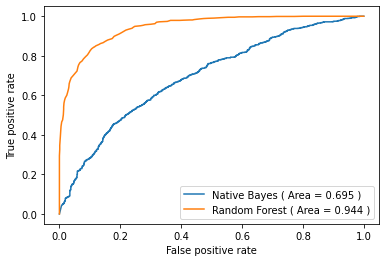

In [118]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr_nb, tpr_nb, label = f"Native Bayes ( Area = {round(auc_nb,3)} )")
plt.plot(fpr_rf, tpr_rf, label = f"Random Forest ( Area = {round(auc_rf,3)} )")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.legend()
plt.show()